In [1]:
import numpy as np
import tensorflow as tf
import random
import os
from beta_vae import VAE
from dsprites import DataManager
import matplotlib.pyplot as plt
import time

# Local Independence Training on dSprites

In this example, we'll test out local independence training on [dSprites](https://github.com/deepmind/dsprites-dataset), a dataset of 64x64 images that are generated based on 5 ground-truth latent factors: shape, scale, rotation, x-, and y-position.

Running naive local independence training with only a few models on dSprites in input space, which is 4096-dimensional, won't work for us -- some of the pixel features in dSprites _never_ change, which means that a model can assign almost infinite importance to one of those pixels--globally--without harming training accuracy. This will make its gradients effectively "orthogonal" to another model that ignores the feature. We might be able to circumvent that problem by training a much larger set of models, but computational constraints prevent us from simultaneously training thousands of them.

Instead, we will solve this problem by running local independence training in a lower dimensional _latent_ space. In particular, we'll use a [$\beta$-VAE](https://arxiv.org/abs/1804.03599) (with credit to Kosuke Miyoshi for providing an [implementation](https://github.com/miyosuda/disentangled_vae)). Since $\beta$-VAEs are designed to _disentangle_ latent generative factors of datapoints into separate dimensions, they bring us closer to the problem of feature selection, which we know our method can solve. We'll actually see that the $\beta$-VAE we train doesn't perfectly disentangle these factors, but we'll still be able to train an ensemble of models each sensitive to only one.

## Load our pretrained $\beta$-VAE

In [2]:
manager = DataManager()
manager.load()
sess = tf.Session()
model = VAE(
    gamma=1.0,
    capacity_limit=20.0,
    capacity_change_duration=100000)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
checkpoint = tf.train.get_checkpoint_state('./beta_vae_checkpoints')
saver.restore(sess, checkpoint.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./beta_vae_checkpoints/checkpoint-7764480


## Verify it can reconstruct dSprites images

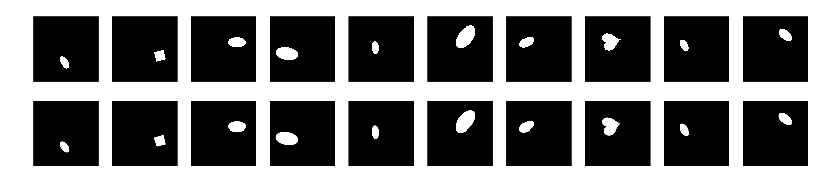

In [3]:
reconstruct_check_images = manager.get_random_images(10)
x_reconstruct = model.reconstruct(sess, reconstruct_check_images)
plt.figure(figsize=(10,2))

def imshow(i):
    plt.imshow(i.reshape(64,64), interpolation='none', cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,i+1)
    imshow(reconstruct_check_images[i])
    plt.subplot(2,10,i+11)
    imshow(x_reconstruct[i])
    
plt.show()

## Compute low-variance dimensions

Although the latent representation our $\beta$-VAE learns is 10-dimensional, when that many latent factors aren't necessary to fully reconstruct inputs, $\beta$-VAEs tend to ignore many of them, creating additional "slack" features. We will want to keep track of these and only penalize cosine similarity in the non-slack feature gradients.

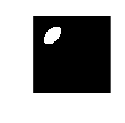

array([ 0.        ,  1.01999998,  0.69999999,  0.        ,  0.        ,
        0.02      ,  0.74000001,  0.61000001,  1.02999997,  0.        ], dtype=float32)

In [4]:
img = manager.get_image(shape=1, scale=2, orientation=5)
plt.figure(figsize=(1,1))
imshow(img)
plt.show()
z_mean, z_log_sigma_sq = model.transform(sess, [img])
z_sigma_sq = np.exp(z_log_sigma_sq)[0]
z_sigma_sq.round(2)

In [5]:
relevant_idxes = np.argwhere(z_sigma_sq.round(2) < 0.7)[:,0]
irrelevant_idxes = np.argwhere(z_sigma_sq.round(2) > 0.7)[:,0]
relevant_I = np.ones(10)
relevant_I[irrelevant_idxes] = 0
I = tf.constant(relevant_I.astype(np.float32))

## Perform latent traversal of low-variance dimensions

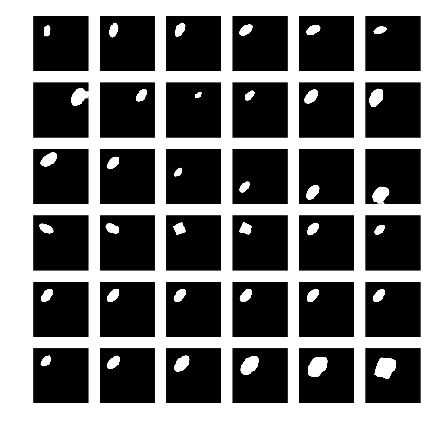

In [6]:
z_m = z_mean[0]
n_z = 10
foo = len(relevant_idxes)
plt.figure(figsize=(5,5))
for j, target_z_index in enumerate(relevant_idxes):                             
  for k, ri in enumerate(relevant_idxes):                                       
    value = -3.0 + (6.0 / 9.0) * (2*k)                          
    z_mean2 = np.zeros((1, n_z))                              
    for i in range(n_z):                                      
      if( i == target_z_index ):                              
        z_mean2[0][i] = value                                 
      else:                                                   
        z_mean2[0][i] = z_m[i]                                
    reconstr_img = model.generate(sess, z_mean2)              
    rimg = reconstr_img[0].reshape(64, 64)
    plt.subplot(foo,foo,j*foo+k+1)
    imshow(rimg)
plt.show()

Here we can see that, while $x$ and $y$-position are fairly well isolated to individual dimensions, they also remain somewhat entangled with scale. Shape and rotation are fairly closely entangled with each other (and perhaps slightly with scale as well).

## Construct our training dataset

In [7]:
# load the dataset, along with the ground-truth latent factors
dataset_zip = np.load('dsprites.npz', encoding = 'latin1')
latents_values  = dataset_zip['latents_values']
medians = np.median(latents_values, axis=0) # compute latent medians

np.random.seed(0)

# shuffle the dataset
indexes = np.arange(len(latents_values))
np.random.shuffle(indexes)

# separate out 10000 images from the full dataset to use for evaluation
X_test = manager.imgs[indexes[:10000]]
Z_test = latents_values[indexes[:10000]]

# compute test sets based on scale, x, and y independently
# being greater than the median
y_test2 = (Z_test[:,2] > medians[2]).astype(int)
y_test4 = (Z_test[:,4] > medians[4]).astype(int)
y_test5 = (Z_test[:,5] > medians[5]).astype(int)

# now compute the training dataset -- take the remaining images
# and determine whether each satisfy each median condition
Z_full = latents_values[indexes[10000:]]
y2 = (Z_full[:,2] > medians[2]).astype(int) # scale
y4 = (Z_full[:,4] > medians[4]).astype(int) # x
y5 = (Z_full[:,5] > medians[5]).astype(int) # y

# introduce train/test ambiguity by limiting to cases where all
# three conditions are true or false
y_sum = y2 + y4 + y5
y0_indexes = np.argwhere(y_sum == 0)[:,0]
y1_indexes = np.argwhere(y_sum == 3)[:,0]

# construct a label-balanced training dataset
n = int(np.floor(min(len(y0_indexes), len(y1_indexes)) / 1000) * 1000)
Z_train = np.vstack([
    latents_values[indexes[10000:]][y0_indexes[:n]],
    latents_values[indexes[10000:]][y1_indexes[:n]]])
X_train = np.vstack([
    manager.imgs[indexes[10000:]][y0_indexes[:n]],
    manager.imgs[indexes[10000:]][y1_indexes[:n]]])
y_train = np.array([0]*n + [1]*n)

# shuffle again
train_shuffle = np.arange(len(y_train))
np.random.shuffle(train_shuffle)
X_train = X_train[train_shuffle]
y_train = y_train[train_shuffle]
Z_train = Z_train[train_shuffle]

# define/import helper functions to perform classification
# and local independence training
def mlp(X, prefix):
  L1 = tf.layers.dense( X, 256, name=prefix+'/1', activation=tf.nn.softplus)
  L2 = tf.layers.dense(L1, 256, name=prefix+'/2', activation=tf.nn.softplus)
  return tf.layers.dense(L2, 2, name=prefix+'/3', activation=None)

def xent(logits,labels):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

def accu(logits,labels):
  return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(labels, 1)), dtype=tf.float32))

def logps(l):
  return l-tf.reduce_logsumexp(l,1,keep_dims=True)
  
from neural_network import onehot, squared_cos_sim
  
def vars_for(prefix):
  return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, prefix)

def reinit_op():
  uninitialized_vars = []
  for var in tf.global_variables():
    try:
      sess.run(var)
    except tf.errors.FailedPreconditionError:
      uninitialized_vars.append(var)
  return tf.variables_initializer(uninitialized_vars)

## Define train operations

In [8]:
mlp_logits = []
mlp_xents = []
mlp_grads = []
mlp_accus = []

X_symb = tf.placeholder(tf.float32, [None, 64, 64])
y_symb = tf.placeholder(tf.float32, [None, 2])
y_trainhot = onehot(y_train, 2)

s = str(time.time())
for i in range(3):
  # Build MLP on top of beta-VAE latent representation (`model.z`)
  mlp_i = mlp(model.z, "{}/{}".format(s,i))
  lossi = xent(mlp_i, y_symb)
  accui = accu(mlp_i, y_symb)
  mlp_logits.append(mlp_i)
  mlp_xents.append(lossi)
  mlp_accus.append(accui)
  # Compute symbolic representation of gradients
  mlp_grads.append(tf.multiply(tf.gradients(logps(mlp_i), model.z)[0], I))

# Sum up cross-entropies
mlp_xent = tf.add_n(mlp_xents)

# Sum up pairwise cosine similarities
mlp_pair = tf.add_n([
    tf.reduce_sum(squared_cos_sim(mlp_grads[i],mlp_grads[j]))
    for i in range(len(mlp_grads))
    for j in range(i+1, len(mlp_grads))])

# Add them to the loss
lambda_pair = 0.1
mlp_loss = mlp_xent + lambda_pair * mlp_pair

# Set up training operations
mlp_optimizer = tf.train.AdamOptimizer()
mlp_train = mlp_optimizer.minimize(mlp_loss, var_list=vars_for(str(s)))
sess.run(reinit_op())

## Train the ensemble

Note: for speed, this version of the notebook defaults to loading an existing ensemble, but you can set retrain=True to run this process over again!

In [10]:
retrain = False # Set this to true to retrain from scratch -- might take a while, though!

if retrain:
  np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
  ops = [mlp_train,lambda_pair*mlp_pair,mlp_xent]+mlp_accus
  for i in range(5000): # this is a decent number of iterations
    i1 = 256*i % len(X_train)
    i2 = 256*(i+1) % len(X_train)
    Xb = X_train[i1:i2].reshape(-1, 64*64)
    yb = y_trainhot[i1:i2]
    if i2 < i1: continue
    results = sess.run(ops, feed_dict={ model.x: Xb, y_symb: yb })
    if i % 10 == 0:
      print('pair: {:.2f}, xent: {:.2f}, acc1: {:.2f}, acc2: {:.2f}, acc3: {:.2f}'.format(*results[1:]))
    if i % 50 == 0:
      print('--')
      a2 = sess.run(mlp_accus, feed_dict={model.x: X_test[:100].reshape(-1,64*64), y_symb: onehot(y_test2[:100])})
      a4 = sess.run(mlp_accus, feed_dict={model.x: X_test[:100].reshape(-1,64*64), y_symb: onehot(y_test4[:100])})
      a5 = sess.run(mlp_accus, feed_dict={model.x: X_test[:100].reshape(-1,64*64), y_symb: onehot(y_test5[:100])})
      print(np.array([a2,a4,a5]).T)
      print('--')
else:
  import pickle
  with open('./dsprites-ensemble.pkl', 'rb') as f:
    vals = pickle.load(f)
    for var, val in zip(vars_for(str(s)), vals):
      sess.run(var.assign(val))

## Train another model normally (for comparison)

In [11]:
s2 = str(time.time())
mlp1_logits = mlp(model.z, s2)
mlp1_loss = xent(mlp1_logits, y_symb)
mlp1_accu = accu(mlp1_logits, y_symb)
mlp1_vars = vars_for(s2)
mlp1_optimizer = tf.train.AdamOptimizer()
mlp1_train = mlp1_optimizer.minimize(mlp1_loss, var_list=mlp1_vars)
sess.run(reinit_op())

for i in range(200): # need many fewer iterations for convergence
  i1 = 256*i % len(X_train)
  i2 = 256*(i+1) % len(X_train)
  if i2 < i1: continue
  _, acc = sess.run([mlp1_train, mlp1_accu], feed_dict={
      model.x: X_train[i1:i2].reshape(-1,64*64), y_symb:y_trainhot[i1:i2]})

## Compute test accuracy for all models for all test sets

In [12]:
accuracy_ops = [mlp1_accu] + mlp_accus # accuracy operations for each model
test_sets = [(X_train, y_train), (X_test, y_test2), (X_test, y_test4), (X_test, y_test5)] # sets for evaluation
indexes = [slice(100*i, 100*(i+1)) for i in range(100)] # batch indexes over each set

accuracy_grid = [[[
   sess.run(op, feed_dict={
      model.x: Xt[idx].reshape(-1, 64*64),
      y_symb: onehot(yt[idx]) })
 for op in accuracy_ops]
 for Xt, yt in test_sets]
 for idx in indexes]

accuracy_grid = np.mean(accuracy_grid, axis=0) # average over batches

## Plot accuracies


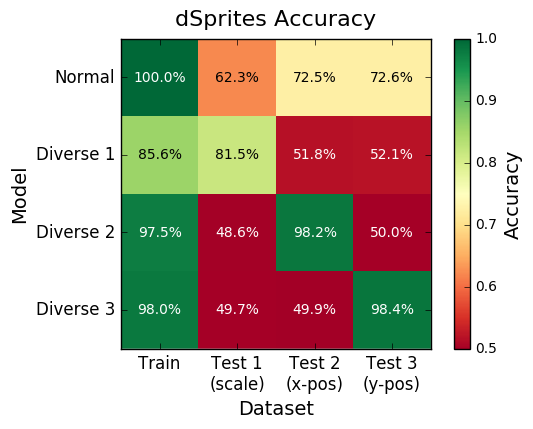

In [13]:
# Reorder models for better display -- if you retrained from scratch, you might want to change this!
reordered = accuracy_grid.T[[0,2,3,1]].T
plt.imshow(reordered.T, interpolation='none',cmap='RdYlGn', vmin=0.5, vmax=1.0)
plt.yticks([0,1,2,3],['Normal', 'Diverse 1', 'Diverse 2', 'Diverse 3'], fontsize=12)
plt.xticks([0,1,2,3],['Train', 'Test 1\n(scale)', 'Test 2\n(x-pos)', 'Test 3\n(y-pos)'], fontsize=12)
for i in range(4):
  for j in range(4):
    plt.text(i,j,'{:.1%}'.format(reordered[i][j]), ha='center', va='center', color=('white' if reordered[i][j] > 0.9 or reordered[i][j] < 0.6 else 'black'))
cb = plt.colorbar()
cb.set_label('Accuracy', fontsize=14)
cb.set_ticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.title('dSprites Accuracy', fontsize=16, y=1.02)
plt.ylabel('Model', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.show()

## Feature visualization to explain each model

Similar to input-space [feature visualization](https://distill.pub/2017/feature-visualization/), as a way of explaining a particular _model_, we'll solve an optimization problem to modify an _image_ to maximize the predicted probability of the positive class. Because we have a nice autoencoder to work with, we'll do this optimization via gradient descent in its latent space (and use its decoder to visualize the resulting series of images).

In [14]:
def normalize(v):
    return v / np.linalg.norm(v)
  
def visualize_progression(viz):
    plt.figure(figsize=(len(viz),1))
    for i in range(len(viz)):
        plt.subplot(1,len(viz),i+1)
        imshow(viz[i])
    plt.show()

def feature_visualize(img, logits, iters=15, eps=0.05):
    logit = logits[:,1] - logits[:,0]
    grad = tf.gradients(logit, model.z)[0]
    z_mean, z_log_sigma_sq = model.transform(sess, [img])
    zs = [z_mean]
    for i in range(iters):
        z = zs[-1]
        grad_val = sess.run(grad, feed_dict={model.z: z})
        z_new = z + eps*normalize(grad_val*relevant_I)
        zs.append(z_new)
    return [model.generate(sess, z).reshape(64,64) for z in zs]          

In [15]:
imgs0 = feature_visualize(img, mlp1_logits,   eps=0.05, iters=80)
imgs1 = feature_visualize(img, mlp_logits[1], eps=0.05, iters=80)
imgs2 = feature_visualize(img, mlp_logits[2], eps=0.05, iters=80)
imgs3 = feature_visualize(img, mlp_logits[0], eps=0.05, iters=80)

### Normal

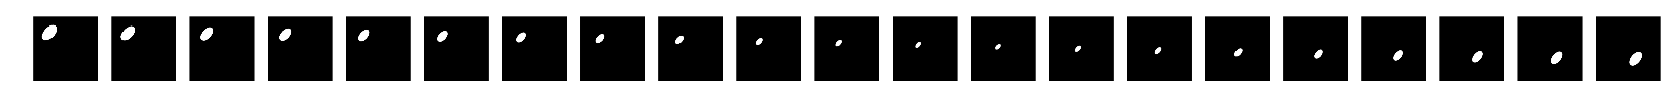

In [16]:
visualize_progression(imgs0[::4])

### Diverse 1

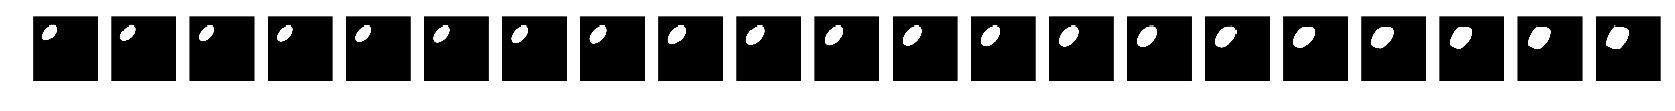

In [17]:
visualize_progression(imgs1[::4])

### Diverse 2

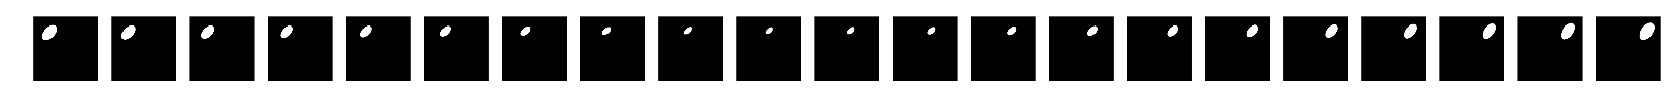

In [18]:
visualize_progression(imgs2[::4])

### Diverse 3

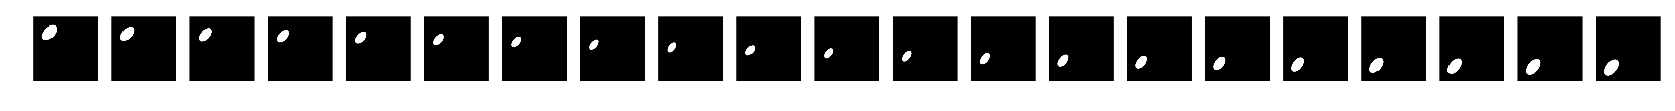

In [19]:
visualize_progression(imgs3[::4])

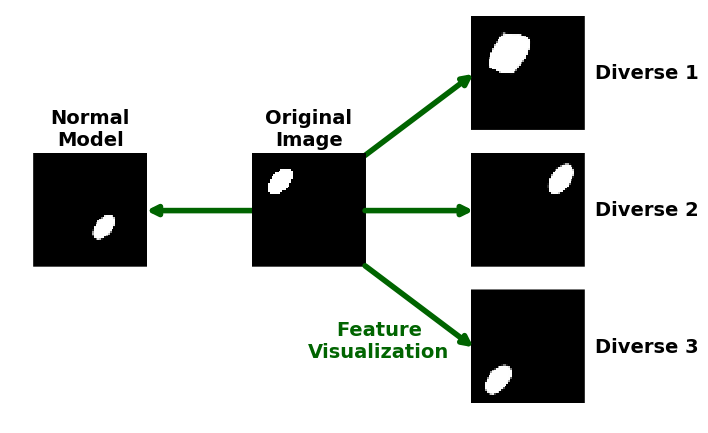

In [20]:
from matplotlib.patches import ConnectionPatch

ts = {'fontweight': 800, 'fontsize': 14}

def add_arrow(ax, xyA, xyB):
  ax.add_artist(ConnectionPatch(
    xyA=xyA, coordsA="data", axesA=ax,
    xyB=xyB, coordsB="data", axesB=ax3,
    color="darkgreen", arrowstyle="<|-", mutation_scale=20, linewidth=4))
  
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(3,3,3); imshow(imgs1[-1]); plt.text(69, 32, 'Diverse 1', va='center', ha='left', **ts)
ax2 = plt.subplot(3,3,4); imshow(imgs0[-1]); plt.title('Normal\nModel', **ts)
ax3 = plt.subplot(3,3,5); imshow(img); plt.title('Original\nImage', **ts)
ax4 = plt.subplot(3,3,6); imshow(imgs2[-1]); plt.text(69, 32, 'Diverse 2', va='center', ha='left', **ts)
ax5 = plt.subplot(3,3,9); imshow(imgs3[-1]); plt.text(69, 32, 'Diverse 3', va='center', ha='left', **ts)
add_arrow(ax1, (1,32), (63,1))
add_arrow(ax4, (1,32), (63,32))
add_arrow(ax5, (1,32), (63,63))
add_arrow(ax2, (63,32), (1,32))
fig.text(0.6,0.25, "Feature\nVisualization", color='darkgreen', ha='center', va='center', **ts)
plt.show()

These visualizations show that each of the three diverse models appears to be sensitive to different latent generative factors, which is what we wanted. Although this example is pretty simple, it's an important demonstration of this technique as a method for obtaining more abstract kinds of diversity in our ensembles.

One important caveat, though: although we trained our classifiers on a dataset where x, y, and size were correlated with each other, we trained our _autoencoder_ on the full dataset, where they weren't. If we hadn't trained our autoencoder in this way, we might not have been able to learn a representation that would have allowed us to train the ensemble we wanted. However, there has been recent progress in learning disentangled representations that [generalize outside the training data](https://arxiv.org/abs/1802.04942) (in that case, being able to produce moustached female faces on CelebA), and even if we can't, our method is still useful in semi-supervised cases, where our training set comes from a much larger unlabeled dataset -- especially when that labeling happened with _selection bias_. In that case, we might be able to learn a good representation for our data, but not a generalizable classifier, which is exactly the setting we considered here.